In [60]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

In [2]:
with open("thoma.json") as f:
    data = json.load(f)

# 0 action

In [3]:
# get action event

list_of_action = []

for v in data["debug"]:
    
    if v["event"] == "action":
        the_point = {
            'frame': v['frame'],
            'char_index': v['char_index'],
        }
        
        try:
            the_point['action'] = v["logs"]['action']
            list_of_action.append(the_point)                
        except Exception: 
            pass
        
    if v["frame"] > 1 * 1272:
        break

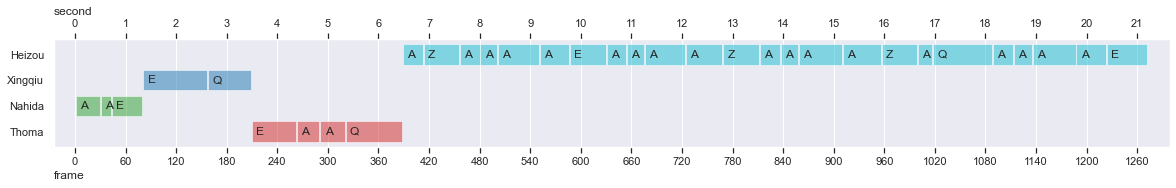

In [119]:
sns.set(style="darkgrid", palette="muted", color_codes=True)
fig, ax = plt.subplots(figsize=(20,2))

the_gap = 1
the_colors = ["red", "green", "blue", "cyan"]
change_action_name = {
    "attack": "A",
    "charge": "Z",
    "skill": "E",
    "burst": "Q",
}

for idx in range(len(list_of_action)):
    
    if list_of_action[idx]["action"] == "swap":
        continue
    
    ax.broken_barh(
        xranges=[
            (list_of_action[idx]["frame"], list_of_action[idx+1]["frame"] - list_of_action[idx]["frame"] - the_gap)
        ], 
        yrange=(list_of_action[idx]["char_index"]+0.1, 0.8), 
        facecolors='tab:%s'%the_colors[list_of_action[idx]["char_index"]], 
        alpha=0.5)
    
    ax.annotate(
        change_action_name[list_of_action[idx]["action"]], 
        xy=(list_of_action[idx]["frame"]+5*the_gap, list_of_action[idx]["char_index"]+0.5), 
        annotation_clip=False, rotation=0, ha="left", va="center")
    
ax.set_yticks([0.5, 1.5, 2.5, 3.5, 4.5])
ax.set_yticklabels(["Thoma", "Nahida", "Xingqiu", "Heizou",""])

ax.set_xticks(range(0,1300,60))

# set x/y range
the_ymax = 4
ax.set_ylim(-the_ymax*0.03, the_ymax*1.03)
the_xmax = 1273
ax.set_xlim(-the_xmax*0.02, the_xmax*1.02)


ax1 = ax.twiny()
the_xmax1 = the_xmax/60
ax1.set_xlim(-the_xmax1*0.02, the_xmax1*1.02)

# same grid
ax1.set_xticks([ idx * the_xmax1 / the_xmax for idx in ax.get_xticks()])
ax1.grid(None)

ax.yaxis.grid(False)

ax.set_xlabel('frame', horizontalalignment='left', x=0)
ax1.set_xlabel('second', horizontalalignment='left', x=0)

plt.show()          

In [20]:
list_of_action

[{'frame': 1, 'char_index': 1, 'action': 'attack'},
 {'frame': 31, 'char_index': 1, 'action': 'attack'},
 {'frame': 44, 'char_index': 1, 'action': 'skill'},
 {'frame': 81, 'char_index': 2, 'action': 'swap'},
 {'frame': 81, 'char_index': 2, 'action': 'skill'},
 {'frame': 158, 'char_index': 2, 'action': 'burst'},
 {'frame': 210, 'char_index': 0, 'action': 'swap'},
 {'frame': 210, 'char_index': 0, 'action': 'skill'},
 {'frame': 263, 'char_index': 0, 'action': 'attack'},
 {'frame': 291, 'char_index': 0, 'action': 'attack'},
 {'frame': 321, 'char_index': 0, 'action': 'burst'},
 {'frame': 389, 'char_index': 3, 'action': 'swap'},
 {'frame': 389, 'char_index': 3, 'action': 'attack'},
 {'frame': 414, 'char_index': 3, 'action': 'charge'},
 {'frame': 457, 'char_index': 3, 'action': 'attack'},
 {'frame': 481, 'char_index': 3, 'action': 'attack'},
 {'frame': 502, 'char_index': 3, 'action': 'attack'},
 {'frame': 551, 'char_index': 3, 'action': 'attack'},
 {'frame': 587, 'char_index': 3, 'action': 's

# 1 element

In [21]:
# get element event

debug_element = {}

for v in data["debug"]:
    
    if v["event"] == "element":
        
        the_target = v["logs"]["target"]
        the_key = "target: %d" % the_target
        
        if the_key not in debug_element:
            debug_element[the_key] = []
            
        debug_element[the_key].append(v)

In [22]:
def get_target_element_points(debug_element, the_target):
    
    the_gap = 0.0000000001

    list_of_points = []

    the_default_point = {

        "frame": 0,
        "abil": None,
        "dendro": 0,
        "hydro": 0,
        "pyro": 0,
        "burning": 0,
        "dendro (fuel)": 0
    }

    list_of_points.append(the_default_point)

    for v in debug_element["target: %d" % the_target]:  


        # get existing

        the_point = the_default_point.copy()
        the_point["frame"] = v["frame"]
        the_point["abil"] = v["logs"]["abil"]
        try:
            for ele in v["logs"]["existing"]:
                tmp = ele.split(': ')
                the_point[tmp[0]] = float(tmp[1])
                if tmp[0] == "burning": # special case: burning
                    the_point["dendro (fuel)"] = 0
                    the_point["burning"] = 0
        except Exception: 
            pass        
        list_of_points.append(the_point)

        # get after
        
        the_point = the_default_point.copy()
        the_point["frame"] = v["frame"] + the_gap

        try:
            for ele in v["logs"]["after"]:
                tmp = ele.split(': ')
                the_point[tmp[0]] = float(tmp[1])
        except Exception: 
            pass                    
        list_of_points.append(the_point)
        
    return list_of_points

In [123]:
def get_iteration_element_plot(list_of_points, the_itr):
    
    sns.set(style="darkgrid", palette="muted", color_codes=True)
    
    frame, dendro, hydro, pyro, burning, notation = [],[],[],[],[],[]    
    for v in list_of_points:
        frame.append(v['frame'])
        dendro.append(v['dendro'])
        hydro.append(v['hydro'])
        pyro.append(v['pyro'])
        burning.append(v['burning'])
        notation.append(v['abil'])

    the_length = 1272 
    
    fig = plt.figure(figsize=(60, 6))

    ax = fig.add_subplot(1,1,1)
    ax.set_title('Iteration %d' % the_itr)

    ax.plot(frame, dendro, color='green', label='dendro')
    ax.plot(frame, hydro, color='blue', label='hydro')
    ax.plot(frame, pyro, color='red', label='pyro')
    # ax.plot(frame, burning, color='black', label='burning')

    for i, txt in enumerate(notation):          
        if frame[i] > the_itr * the_length:
            break
        if frame[i] > (the_itr - 1) * the_length: 
            ax.annotate(txt, xy=(frame[i], -8), annotation_clip=False, rotation=90, ha="right", va="top")

    ax.set_xlim([(the_itr - 1) * the_length, 1 + the_itr * the_length])        
    ax.set_ylim([0, 50])  

    def frame2second(x):
        return x / 60

    def second2frame(x):
        return x * 60

    secax = ax.secondary_xaxis('top', functions=(frame2second, second2frame)) 

    ax.set_xlabel('frame', horizontalalignment='left', x=0)
    secax.set_xlabel('second', horizontalalignment='left', x=0)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(60))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(12))

    secax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    secax.xaxis.set_minor_locator(ticker.MultipleLocator(0.2))

    plt.legend()
    
    return fig

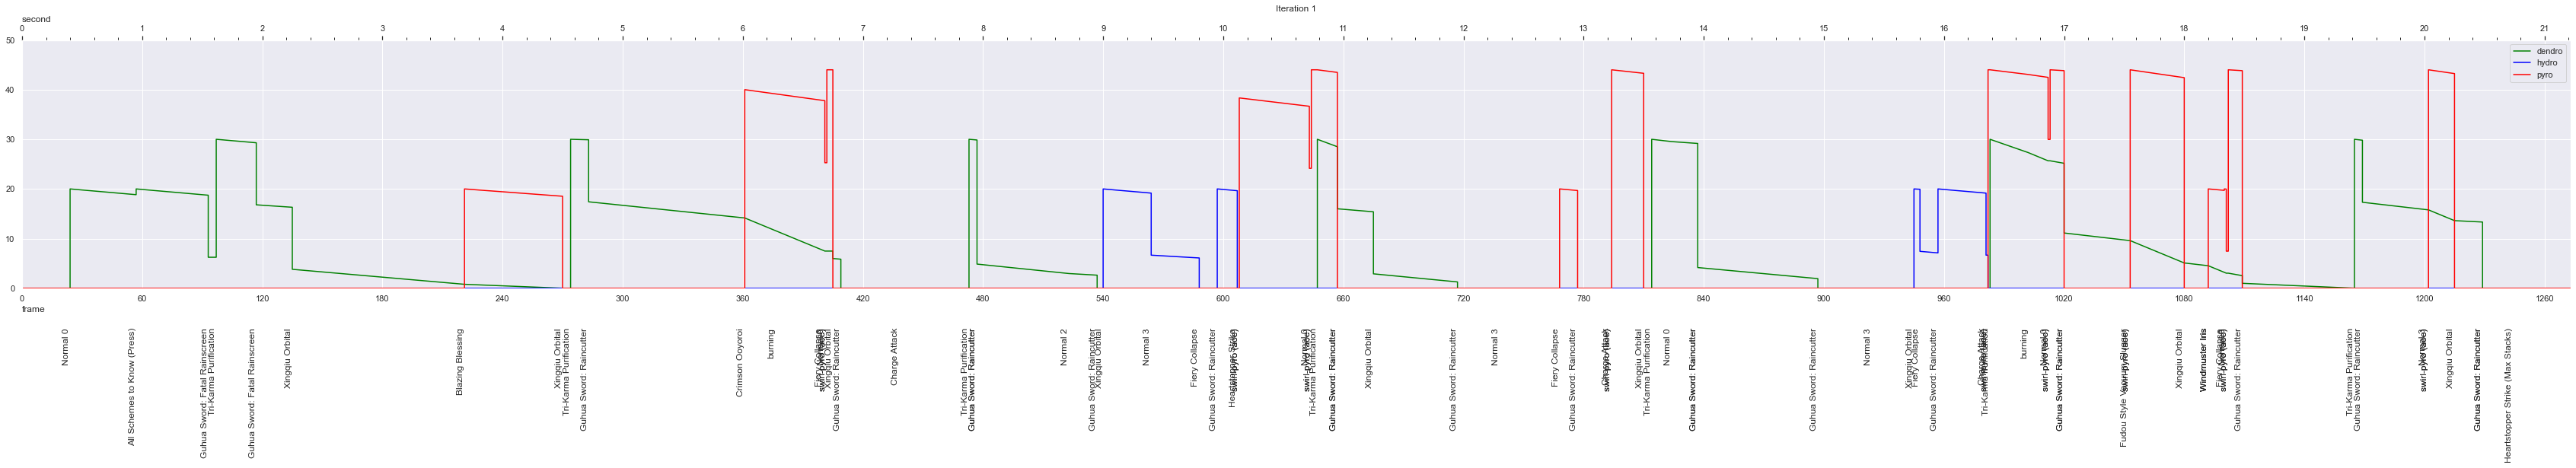

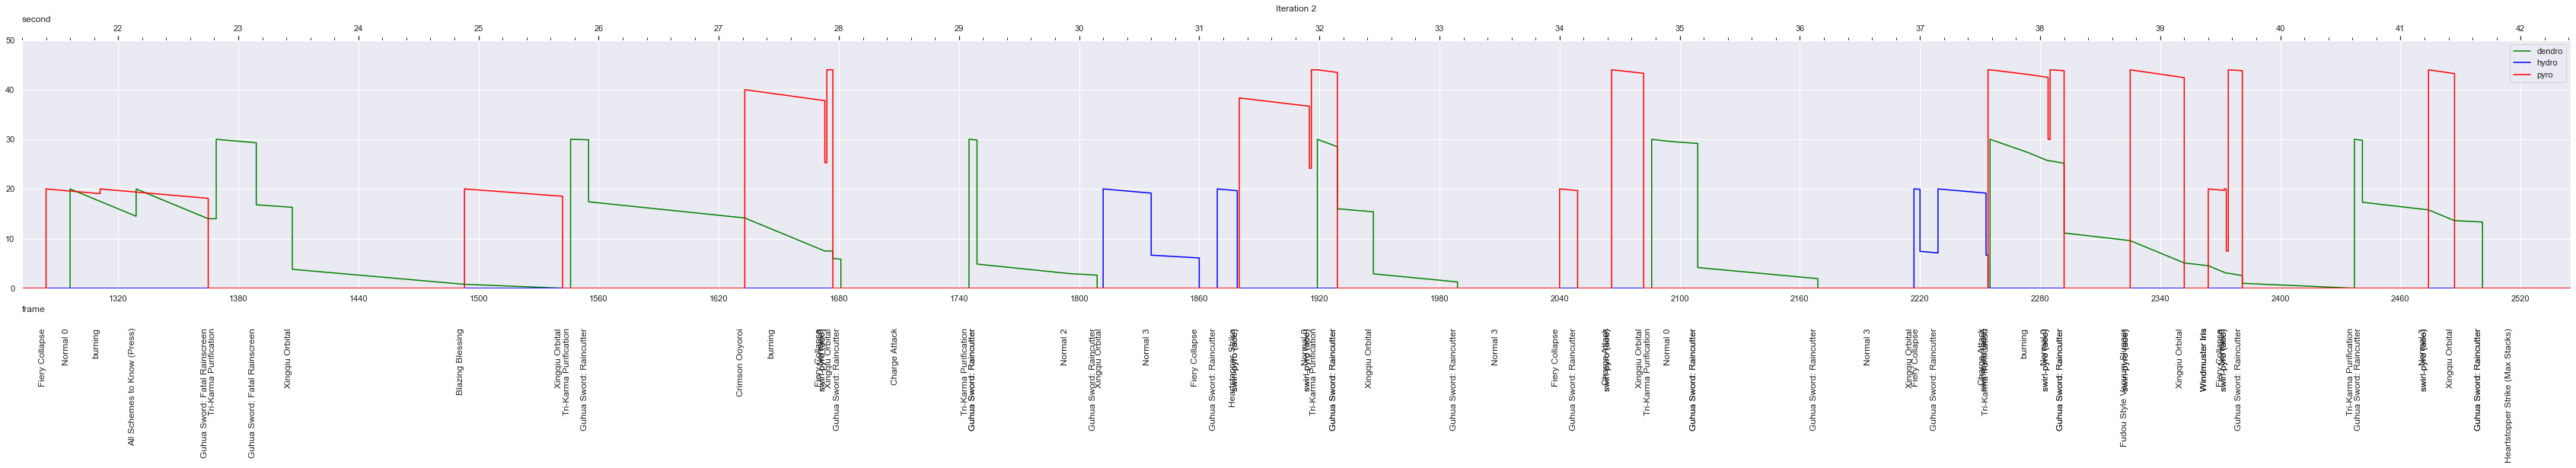

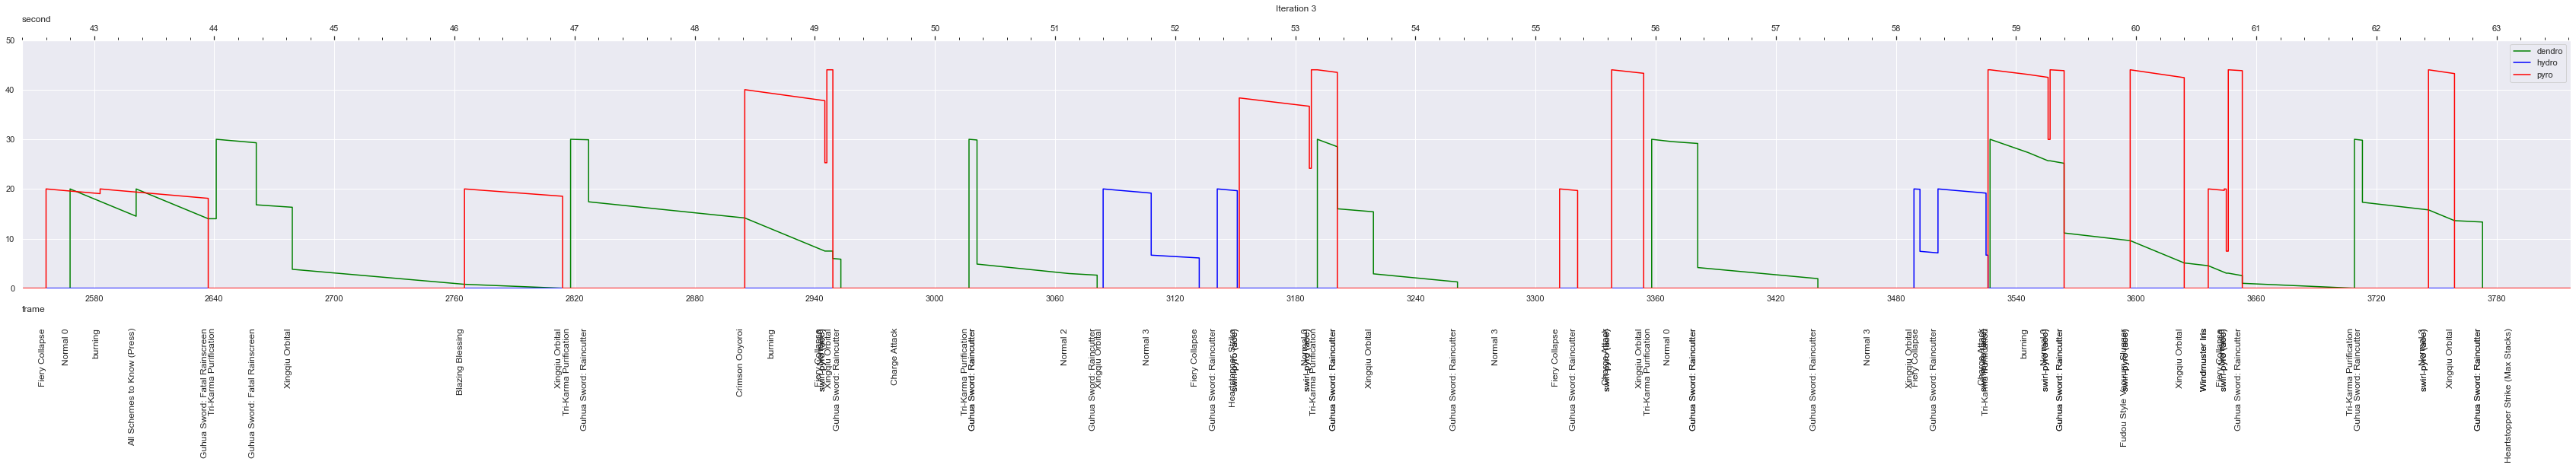

In [124]:
list_of_target1_element_points = get_target_element_points(debug_element = debug_element, the_target = 1)

fig_element_target1_iteration1 = get_iteration_element_plot(list_of_points = list_of_target1_element_points, the_itr = 1)
fig_element_target1_iteration2 = get_iteration_element_plot(list_of_points = list_of_target1_element_points, the_itr = 2)
fig_element_target1_iteration3 = get_iteration_element_plot(list_of_points = list_of_target1_element_points, the_itr = 3)

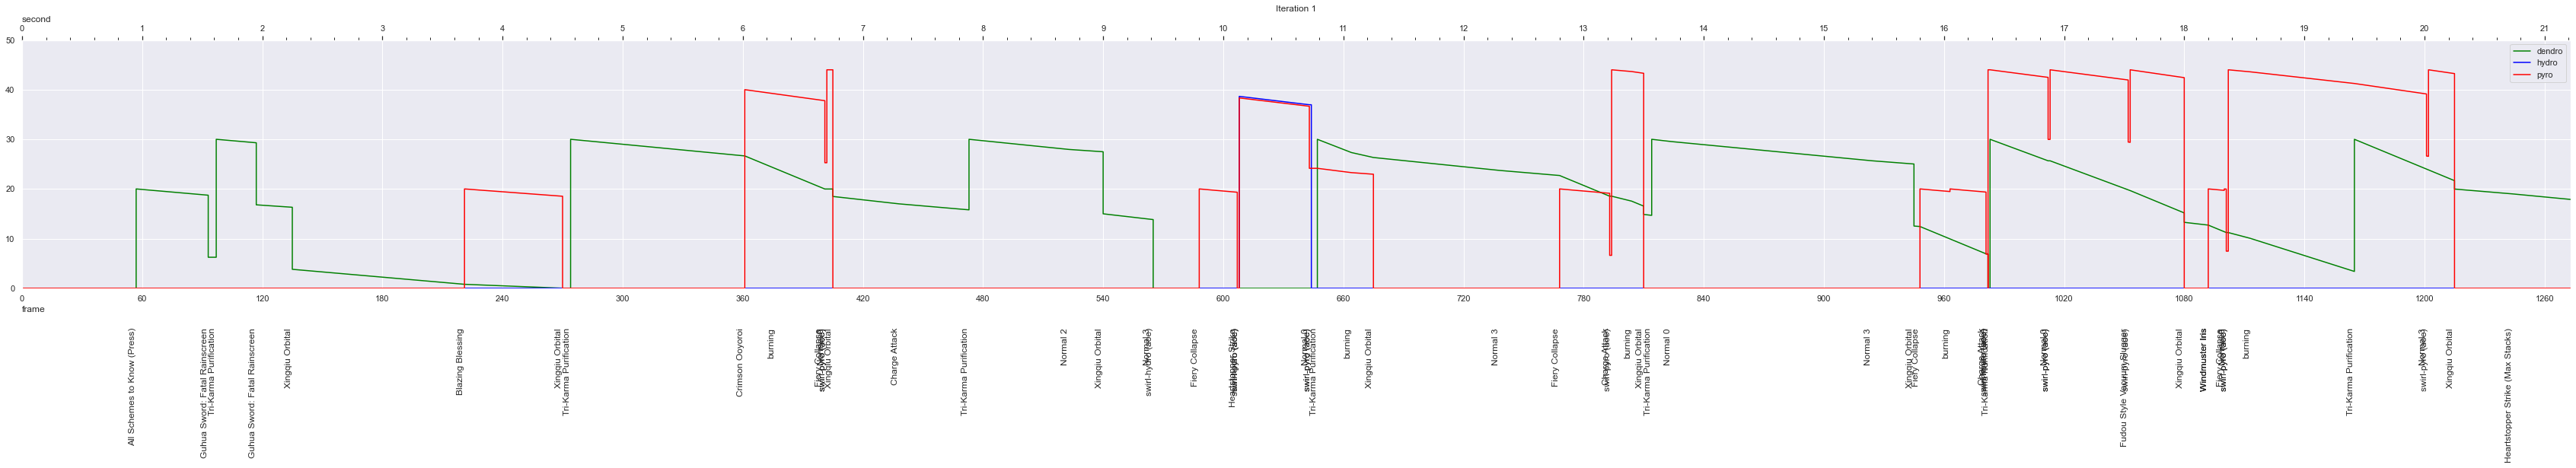

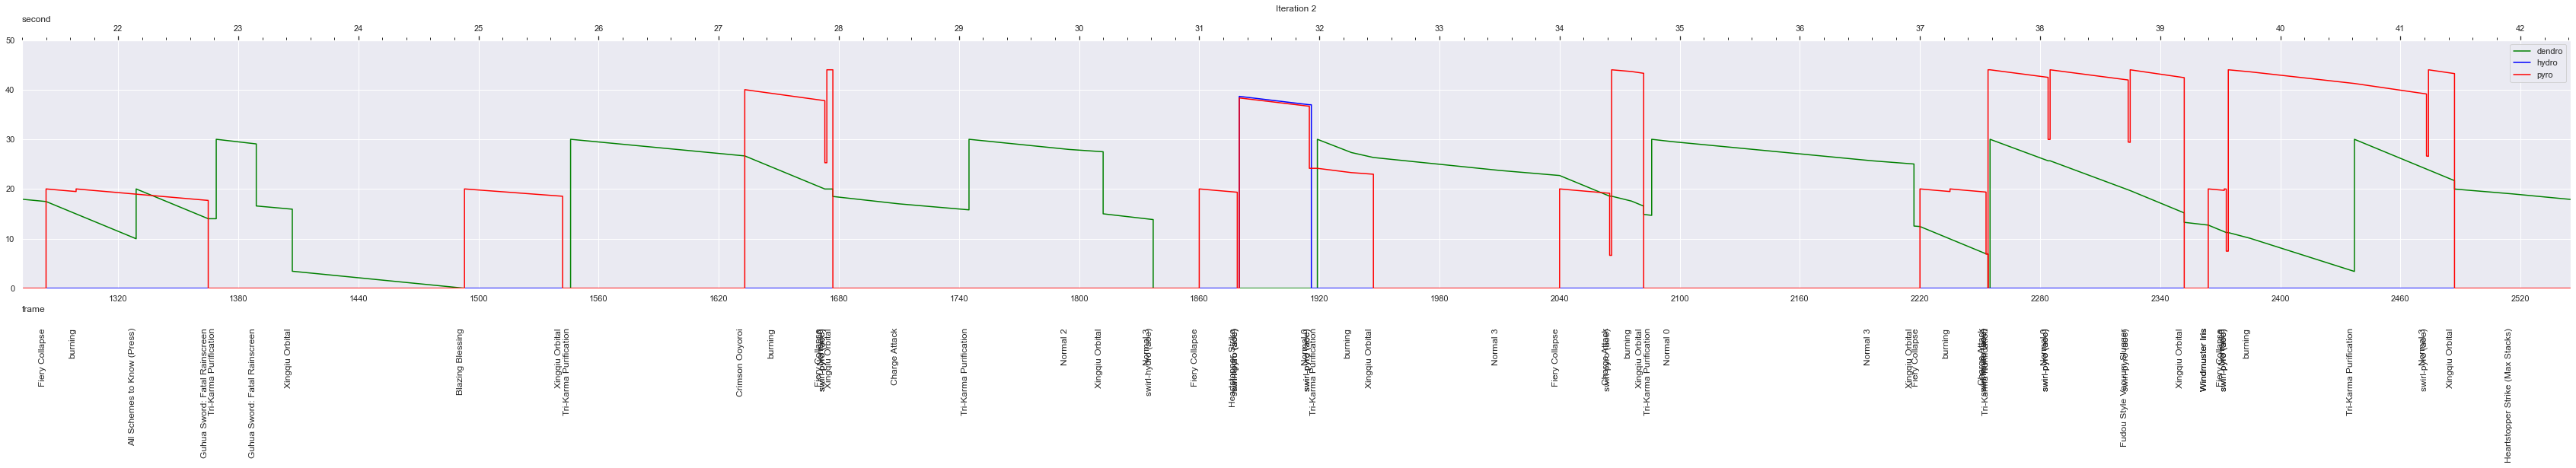

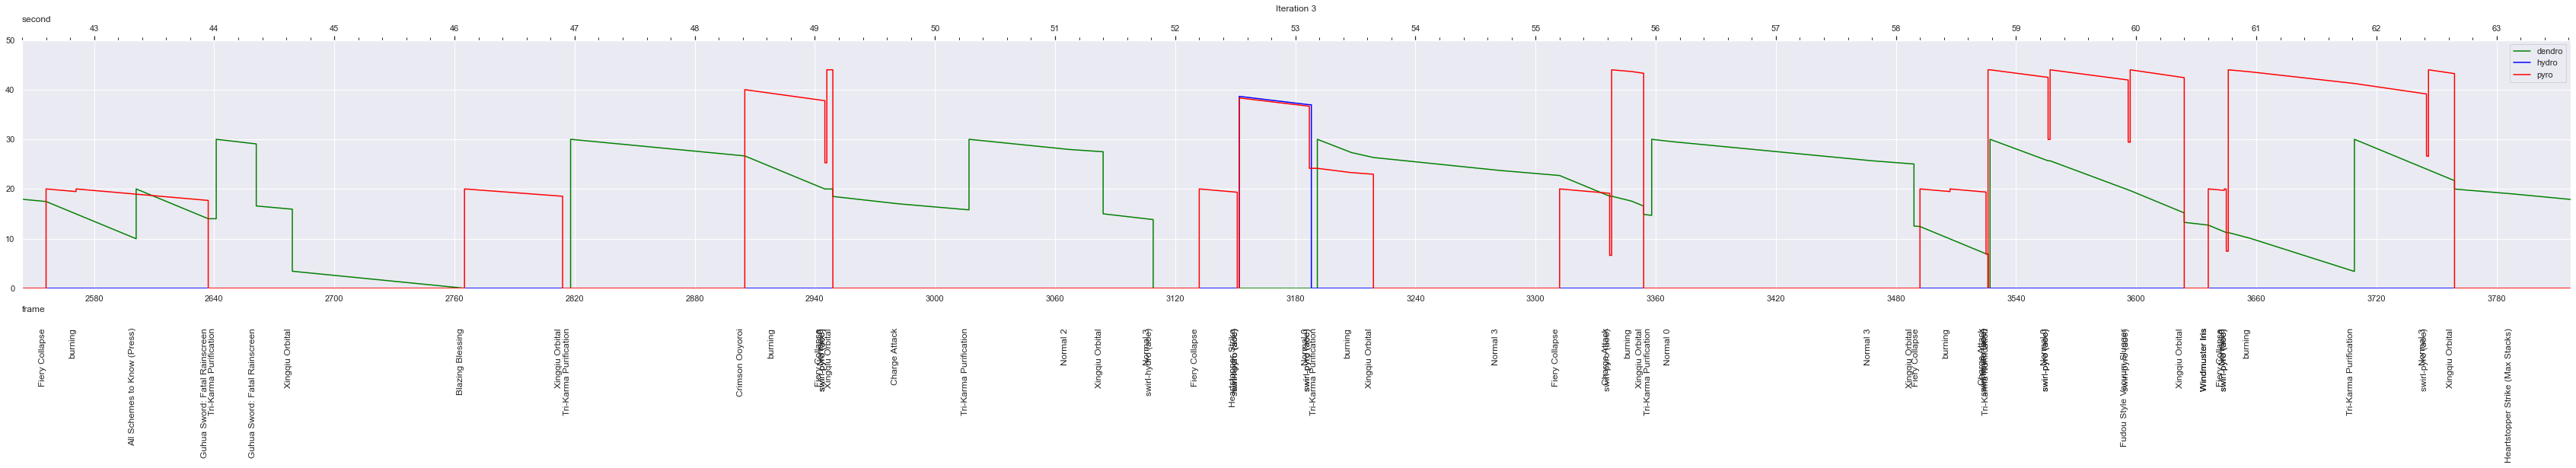

In [125]:
list_of_target2_element_points = get_target_element_points(debug_element = debug_element, the_target = 2)

fig_element_target2_iteration1 = get_iteration_element_plot(list_of_points = list_of_target2_element_points, the_itr = 1)
fig_element_target2_iteration2 = get_iteration_element_plot(list_of_points = list_of_target2_element_points, the_itr = 2)
fig_element_target2_iteration3 = get_iteration_element_plot(list_of_points = list_of_target2_element_points, the_itr = 3)

In [26]:
data["debug"]

[{'char_index': 0,
  'ended': -1,
  'event': 'status',
  'frame': 0,
  'logs': {'expiry': -1, 'key': 'kitain-skill-dmg-buff', 'overwrite': False},
  'msg': 'attack mod added',
  'ordering': {'expiry': 2, 'key': 1, 'overwrite': 0}},
 {'char_index': 0,
  'ended': -1,
  'event': 'status',
  'frame': 0,
  'logs': {'expiry': -1, 'key': 'flower-2pc', 'overwrite': False},
  'msg': 'stat mod added',
  'ordering': {'expiry': 2, 'key': 1, 'overwrite': 0}},
 {'char_index': 0,
  'ended': -1,
  'event': 'status',
  'frame': 0,
  'logs': {'expiry': -1, 'key': 'flower-4pc', 'overwrite': False},
  'msg': 'react bonus mod added',
  'ordering': {'expiry': 2, 'key': 1, 'overwrite': 0}},
 {'char_index': 1,
  'ended': -1,
  'event': 'status',
  'frame': 0,
  'logs': {'expiry': -1, 'key': 'dm-2pc', 'overwrite': False},
  'msg': 'stat mod added',
  'ordering': {'expiry': 2, 'key': 1, 'overwrite': 0}},
 {'char_index': 2,
  'ended': -1,
  'event': 'status',
  'frame': 0,
  'logs': {'expiry': -1, 'key': 'esr-2p

# 2  expected damage

In [128]:
 # get calc event

debug_calc = {}

for v in data["debug"]:

    if v["event"] == "calc":

        the_target = v["logs"]["target"]
        the_key = "target: %d" % the_target

        if the_key not in debug_calc:
            debug_calc[the_key] = []

        debug_calc[the_key].append(v)

In [132]:
the_target = 2
list_of_points = []

for v in debug_calc["target: %d" % the_target]:

    # get existing

    the_point = {            
        "frame": v["frame"],
        "char_index": v["char_index"],
        "abil": v["logs"]["abil"],
        "reaction_type": v["logs"]["reaction_type"],
        "avg_crit_dmg": v["logs"]["avg_crit_dmg"]
    }

    list_of_points.append(the_point)

In [133]:
# sum damage by char and abil

df_damage_detail = pd.DataFrame(list_of_points)

In [134]:
df_damage_detail

,frame,char_index,abil,reaction_type,avg_crit_dmg
0,57,1,All Schemes to Know (Press),,1982.217890
1,93,2,Guhua Sword: Fatal Rainscreen,,7933.120959
2,97,1,Tri-Karma Purification,,11189.691867
3,117,2,Guhua Sword: Fatal Rainscreen,,9028.647186
4,135,2,Xingqiu Orbital,,0.000000
...,...,...,...,...,...
1608,12655,3,Normal 3,,384.529173
1609,12663,3,Normal 3,,454.506804
1610,12663,2,Xingqiu Orbital,vaporize,0.000000
1611,12668,0,Fiery Collapse,,1321.882466


In [135]:
df_damage_detail['avg_crit_dmg'].sum()

16866384.102665983

In [32]:
df_damage_detail.groupby(['char_index'])['avg_crit_dmg'].sum().reset_index()

,char_index,avg_crit_dmg
0,0,1.274346e+07
1,1,9.945438e+05
2,2,2.481418e+06
3,3,2.682801e+06


In [126]:
tmp = df_damage_detail.groupby(['char_index','abil', "reaction_type"])['avg_crit_dmg'].sum().reset_index()
tmp

,char_index,abil,reaction_type,avg_crit_dmg
0,0,Blazing Blessing,,3.042771e+04
1,0,Crimson Ooyoroi,,1.633025e+04
2,0,Fiery Collapse,,1.701167e+05
3,0,Fiery Collapse,vaporize,2.642158e+04
4,0,Normal 0,,6.961275e+03
5,0,Normal 1,,6.840929e+03
6,0,burgeon,,1.243193e+07
7,0,burning,,5.443171e+04
8,1,All Schemes to Know (Press),,2.422103e+04
9,1,Normal 0,,1.110484e+04


In [136]:
df_damage_detail.to_csv('thoma_damage.csv', index=False)